# Djokovic ML model

Here we want to analyze Djokovic's data and use ML to predict some stats. We choose Djokovic because he has the highest number of played matches (= more data) 

We start by importing some general modules. More modules will be imported throurough the project, when needed.

In [1]:
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

Let us query all Djokovic's matches from the database and let us list all the features with the corresponding type. Let us then visualize the dataset.

In [2]:
conn = sqlite3.connect('../data.db')
df = pd.read_sql_query("SELECT * FROM djokovic ORDER BY win", conn) # select all Djokovic's matches
#print(df.columns)
print(df.dtypes)

id                         int64
tourney_name              object
surface                   object
tourney_date              object
best_of                    int64
minutes                  float64
tot_games                float64
round                     object
ace                      float64
df                       float64
firstWon                 float64
firstIn                  float64
win                       object
rank                     float64
serve_games              float64
serve_points             float64
opponent                  object
opponent_ace             float64
opponent_df              float64
opponent_firstWon        float64
opponent_firstIn         float64
opponent_rank            float64
opponent_serve_games     float64
opponent_serve_points    float64
opponent_hand             object
opponent_height          float64
dtype: object


In [3]:
from IPython.display import display, HTML

# Generate HTML table
def display_scrollable_table(df):
    html = f"""
    <style>
        .dataframe-container {{
            max-height: 500px;
            overflow-y: scroll;
            border: 1px solid #ccc;
        }}
        table {{
            width: 100%;
            border-collapse: collapse;
        }}
        th, td {{
            padding: 8px;
            text-align: left;
            border-bottom: 1px solid #ddd;
        }}
        thead th {{
            position: sticky;
            top: 0;
            background: white;
            z-index: 2;
        }}
    </style>
    <div class="dataframe-container">
        {df.to_html(index=False)}
    </div>
    """
    display(HTML(html))

# Display table
display_scrollable_table(df)

id,tourney_name,surface,tourney_date,best_of,minutes,tot_games,round,ace,df,firstWon,firstIn,win,rank,serve_games,serve_points,opponent,opponent_ace,opponent_df,opponent_firstWon,opponent_firstIn,opponent_rank,opponent_serve_games,opponent_serve_points,opponent_hand,opponent_height
4,Australian Open,Hard,20180115.0,5,201.0,36.0,R16,2.0,9.0,53.0,81.0,no,14.0,18.0,130.0,Hyeon Chung,1.0,2.0,59.0,91.0,58.0,18.0,136.0,R,188.0
5,Indian Wells Masters,Hard,20180305.0,3,150.0,29.0,R64,4.0,4.0,39.0,60.0,no,13.0,14.0,94.0,Taro Daniel,1.0,8.0,37.0,52.0,109.0,15.0,107.0,R,191.0
6,Miami Masters,Hard,20180319.0,3,67.0,19.0,R64,2.0,3.0,18.0,34.0,no,12.0,10.0,55.0,Benoit Paire,9.0,2.0,24.0,32.0,47.0,9.0,48.0,R,196.0
9,Monte Carlo Masters,Clay,20180416.0,3,149.0,29.0,R16,3.0,2.0,46.0,72.0,no,13.0,15.0,114.0,Dominic Thiem,9.0,5.0,38.0,51.0,7.0,14.0,95.0,R,185.0
10,Barcelona,Clay,20180423.0,3,99.0,24.0,R32,5.0,2.0,34.0,48.0,no,12.0,12.0,61.0,Martin Klizan,4.0,4.0,28.0,42.0,140.0,12.0,67.0,L,190.0
12,Madrid Masters,Clay,20180507.0,3,102.0,26.0,R32,2.0,2.0,33.0,48.0,no,12.0,13.0,67.0,Kyle Edmund,5.0,2.0,31.0,45.0,22.0,13.0,71.0,R,188.0
17,Rome Masters,Clay,20180514.0,3,116.0,21.0,SF,4.0,0.0,27.0,45.0,no,18.0,11.0,63.0,Rafael Nadal,1.0,2.0,25.0,39.0,2.0,10.0,65.0,L,185.0
22,Roland Garros,Clay,20180528.0,5,206.0,40.0,QF,5.0,2.0,57.0,87.0,no,22.0,20.0,127.0,Marco Cecchinato,6.0,5.0,73.0,117.0,72.0,20.0,157.0,R,185.0
27,Queen's Club,Grass,20180618.0,3,177.0,33.0,F,12.0,5.0,62.0,81.0,no,22.0,16.0,109.0,Marin Cilic,18.0,6.0,46.0,54.0,6.0,17.0,113.0,R,198.0
37,Canada Masters,Hard,20180806.0,3,137.0,30.0,R16,11.0,4.0,41.0,56.0,no,10.0,14.0,97.0,Stefanos Tsitsipas,11.0,2.0,46.0,55.0,27.0,16.0,92.0,R,193.0


Before diving into the investigation of the dataset, let us do some basic operations to better represent the data we need.

Split date into month and year

In [4]:
# Separate year from month
yyyy, mm = [[], []]
for el in df["tourney_date"]:
    yyyy.append(int(el[:4]))
    mm.append(int(el[4:6]))
df["yyyy"] = yyyy
df["mm"] = mm
df = df.drop("tourney_date", axis=1)

Remove rows with NaN output

In [5]:
df = df[df['win'].notna()]

Stats normalization from absolute counts to relative percentage

In [6]:
cols_to_norm = ['ace', 'df', 'firstWon', 'firstIn']
for col in cols_to_norm:
    df[col + "_rate"] = df[col] / df.serve_points

cols_to_norm = ['opponent_ace', 'opponent_df', 'opponent_firstWon', 'opponent_firstIn']
for col in cols_to_norm:
    df[col + "_rate"] = df[col] / df.opponent_serve_points

cols_to_norm = ['minutes', 'tot_games', 'serve_games', 'serve_points', 'opponent_serve_games', 'opponent_serve_points']
for col in cols_to_norm:
    df[col + "_per_set"] = df[col] / df.best_of

Encode victory (yes/no) into number (1/0)

In [7]:
encoded_y = []
for el in df['win']:
    if "yes" == el:
        encoded_y.append(0.)
    else:
        encoded_y.append(1.)
y = pd.DataFrame({"win": encoded_y}) # dependent variable 
df["win"] = encoded_y

## Data exploration

Long-tailed distributions are typically not very nice to work with. Hence, we measure the kurtosis of each distribution and if it is larger than 3 stddev, we work on it.

df 3.2831993706348923


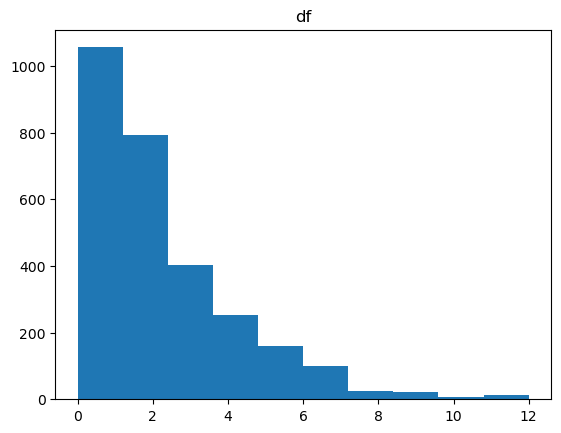

rank 28.78852224021656


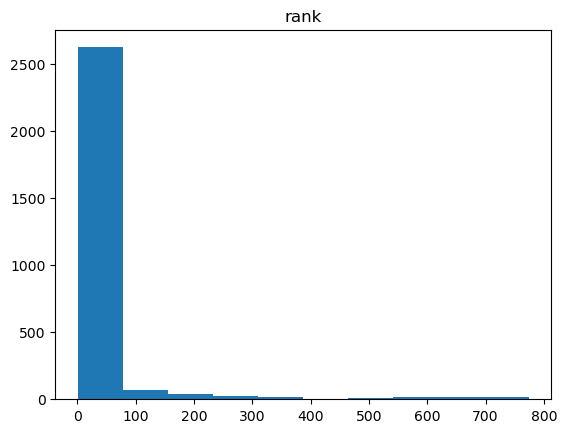

opponent_ace 6.871428158781516


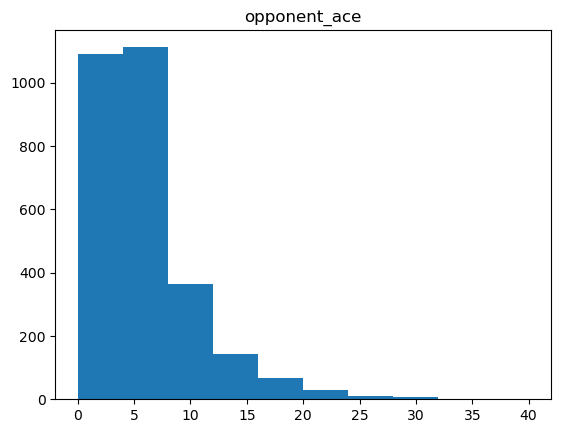

opponent_rank 42.793004040541405


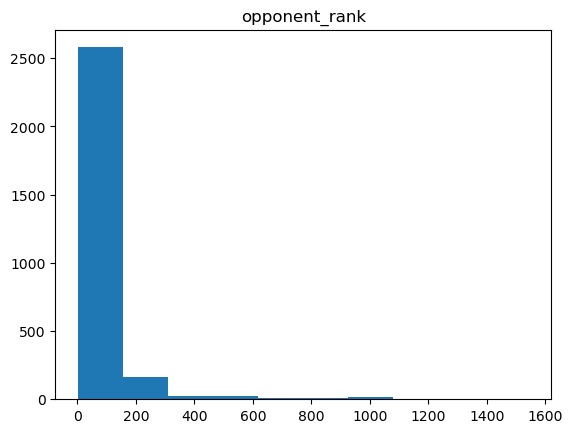

opponent_df_rate 10.28210640819931


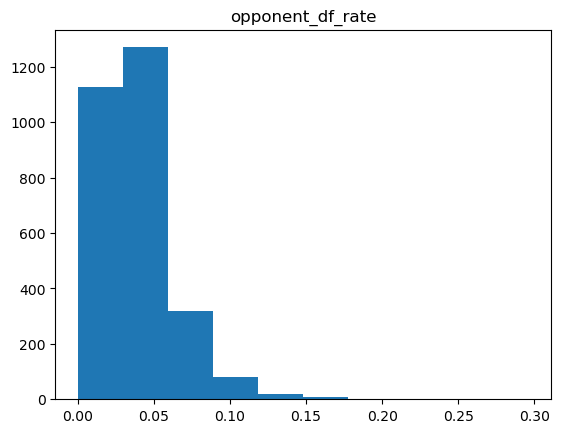

In [8]:
from scipy.stats import kurtosis
from sklearn.impute import SimpleImputer

numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

longtail_features = []

count = 0
for feature in df.select_dtypes(include=['int64', 'float64']).columns:
    df[feature] = df[feature].fillna(value=df[feature].mean())
    kurt = kurtosis(df[feature])
    if kurt > 3:
        print(feature, kurt)
        longtail_features.append(feature)
        plt.hist(df[feature])
        plt.title(feature)
        plt.show()

Correlation matrix

In [9]:
print(df.columns)
corr_matrix = df.select_dtypes(include="float64").corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

Index(['id', 'tourney_name', 'surface', 'best_of', 'minutes', 'tot_games',
       'round', 'ace', 'df', 'firstWon', 'firstIn', 'win', 'rank',
       'serve_games', 'serve_points', 'opponent', 'opponent_ace',
       'opponent_df', 'opponent_firstWon', 'opponent_firstIn', 'opponent_rank',
       'opponent_serve_games', 'opponent_serve_points', 'opponent_hand',
       'opponent_height', 'yyyy', 'mm', 'ace_rate', 'df_rate', 'firstWon_rate',
       'firstIn_rate', 'opponent_ace_rate', 'opponent_df_rate',
       'opponent_firstWon_rate', 'opponent_firstIn_rate', 'minutes_per_set',
       'tot_games_per_set', 'serve_games_per_set', 'serve_points_per_set',
       'opponent_serve_games_per_set', 'opponent_serve_points_per_set'],
      dtype='object')


,minutes,tot_games,ace,df,firstWon,firstIn,win,rank,serve_games,serve_points,opponent_ace,opponent_df,opponent_firstWon,opponent_firstIn,opponent_rank,opponent_serve_games,opponent_serve_points,opponent_height,ace_rate,df_rate,firstWon_rate,firstIn_rate,opponent_ace_rate,opponent_df_rate,opponent_firstWon_rate,opponent_firstIn_rate,minutes_per_set,tot_games_per_set,serve_games_per_set,serve_points_per_set,opponent_serve_games_per_set,opponent_serve_points_per_set
minutes,1.000000,0.905150,0.337591,0.389134,0.850159,0.885766,0.125369,0.000953,0.901576,0.917353,0.414987,0.264393,0.859804,0.876864,-0.064250,0.903054,0.907224,0.015067,-0.168477,0.005125,-0.223669,-0.065519,0.071366,-0.187527,0.255364,0.116278,0.768164,0.667253,0.658815,0.666911,0.668211,0.675230
tot_games,0.905150,1.000000,0.447102,0.387762,0.926749,0.925669,0.090267,0.008275,0.996853,0.943336,0.529672,0.319843,0.904689,0.896798,-0.038237,0.996887,0.939385,0.028197,-0.080329,-0.001402,-0.116382,-0.013525,0.164743,-0.158740,0.288602,0.095051,0.584423,0.667519,0.658367,0.599620,0.669176,0.609225
ace,0.337591,0.447102,1.000000,0.149551,0.503419,0.387515,-0.083363,-0.004615,0.447402,0.370039,0.333607,0.138487,0.418821,0.399392,0.022393,0.444011,0.421603,-0.005966,0.783038,-0.010055,0.279241,0.106791,0.168985,-0.079398,0.145421,0.027868,0.134213,0.222333,0.218581,0.148838,0.223576,0.210138
df,0.389134,0.387762,0.149551,1.000000,0.352965,0.379274,0.139414,0.025371,0.386184,0.458982,0.174509,0.192073,0.322605,0.314956,-0.003741,0.386911,0.357480,-0.034317,-0.110808,0.855927,-0.294415,-0.290355,0.050431,-0.005099,0.084590,-0.038647,0.322091,0.334559,0.332098,0.405748,0.333301,0.293822
firstWon,0.850159,0.926749,0.503419,0.352965,1.000000,0.959330,0.010161,0.000876,0.928910,0.925850,0.530557,0.295287,0.860553,0.846326,-0.032403,0.918815,0.875148,0.059928,-0.010163,-0.037612,0.105576,0.193308,0.188375,-0.148227,0.300063,0.123017,0.539598,0.594247,0.591834,0.595391,0.590089,0.549685
firstIn,0.885766,0.925669,0.387515,0.379274,0.959330,1.000000,0.131789,0.010527,0.926062,0.972173,0.482692,0.281060,0.854030,0.842203,-0.047688,0.919498,0.869882,0.028280,-0.143070,-0.026627,-0.103525,0.165311,0.143195,-0.160209,0.307501,0.128215,0.609243,0.636046,0.632405,0.683626,0.632636,0.580933
win,0.125369,0.090267,-0.083363,0.139414,0.010161,0.131789,1.000000,0.075969,0.075813,0.151424,0.114318,-0.080179,0.190162,0.090389,-0.055145,0.104081,0.060301,-0.012283,-0.163593,0.092135,-0.365908,-0.088094,0.129948,-0.126756,0.376168,0.118247,0.205949,0.198307,0.180393,0.248998,0.213729,0.148563
rank,0.000953,0.008275,-0.004615,0.025371,0.000876,0.010527,0.075969,1.000000,0.007718,0.013361,-0.008243,0.017332,0.007318,0.004765,0.582883,0.008778,0.005431,-0.062540,-0.009793,0.023605,-0.030481,-0.009772,-0.013647,0.012297,0.007283,0.000425,0.001841,0.011139,0.010322,0.016736,0.011820,0.007381
serve_games,0.901576,0.996853,0.447402,0.386184,0.928910,0.926062,0.075813,0.007718,1.000000,0.943423,0.524465,0.318834,0.894893,0.888446,-0.036879,0.987500,0.930384,0.027943,-0.078406,-0.002988,-0.112057,-0.012647,0.162883,-0.154114,0.283350,0.095153,0.577018,0.658940,0.657930,0.596152,0.652693,0.593526
serve_points,0.917353,0.943336,0.370039,0.458982,0.925850,0.972173,0.151424,0.013361,0.943423,1.000000,0.482767,0.292890,0.867177,0.851656,-0.052097,0.937361,0.886849,0.016774,-0.179789,0.048540,-0.254499,-0.055072,0.138843,-0.159550,0.306359,0.106586,0.658460,0.678495,0.674902,0.733700,0.674570,0.618755


In [10]:
top4 = corr_matrix["win"].sort_values(ascending=False)[:4]
print(top4.index)

Index(['win', 'opponent_firstWon_rate', 'serve_points_per_set',
       'opponent_serve_games_per_set'],
      dtype='object')


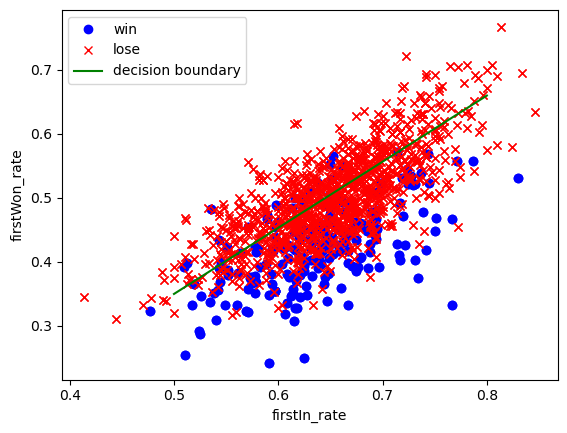

In [11]:
from sklearn.linear_model import LogisticRegression

win_data = df[df["win"] == 1]
lose_data = df[df["win"] == 0]

f1 = "firstIn_rate"
f2 = "firstWon_rate"

# Visualizzazione dei dati
plt.plot(win_data[f1], win_data[f2], "bo", label="win")
plt.plot(lose_data[f1], lose_data[f2], "rx", label="lose")

xvals = np.linspace(0.5, 0.8, 100)
m = (0.35 - 0.66) / (0.5 - 0.8)
q = 0.35 - m * 0.5
yvals = m * xvals + q
plt.plot(xvals, yvals, "g-", label="decision boundary")

plt.xlabel(f1)
plt.ylabel(f2) 
plt.legend()
plt.show()

## Data engineering

The first thing we do is to encode the tournament round into numbers, to create a hierarcy

In [12]:

print(df["round"].value_counts())
for el in ["Q1", "Q2", "Q3", "BR"]:
    df.drop(df[df["round"] == el].index, inplace=True)
print(df["round"].value_counts())
round_dict = {"R128": 0, "R64": 1, "R32": 2, "R32": 3, "R16": 4, "RR": 5, "QF": 6, "SF": 7, "F": 8}
df["round_n"] = [round_dict[round_key] for round_key in df["round"]]
df.drop("round", inplace=True, axis=1)


round
R32     550
R16     516
QF      458
SF      398
F       290
R64     230
RR      216
R128    150
BR        6
Q1        6
Q2        6
Q3        6
Name: count, dtype: int64
round
R32     550
R16     516
QF      458
SF      398
F       290
R64     230
RR      216
R128    150
Name: count, dtype: int64


Divide ranks into bins

In [13]:
edges = [0,1,2,3,6,10,20,50,100,1000]
df['rank'] = pd.cut(df['rank'], bins=edges, labels=range(len(edges)-1)).astype(str)
df['opponent_rank'] = pd.cut(df['opponent_rank'], bins=edges, labels=range(len(edges)-1)).astype(str)

We have to encode the date in some way. Here I chose to store only the year and the month of the match, and I encoded the month as a cyclical feature (December close to January). Other choices are possibile: for example one could consider one unique monotonic feature such as date = year*12 + month

In [14]:
from feature_engine.creation import CyclicalFeatures
df_date = pd.DataFrame({"year": df["yyyy"], "month": df["mm"]})
# Convert to cyclical feature
cyclical = CyclicalFeatures(variables=None, drop_original=True)
df_date = cyclical.fit_transform(df_date)
# Merge into dataframe
df = df.drop(columns=["yyyy", "mm"], axis=1)
df = pd.concat([df, df_date], axis=1)

Now we want to create data pipelines. I decided to make three different pipelines: A) numerical data, B) categorical data  
- numerical data -> replace NaN with mean value -> scale to zero mean unit variance distribution  
- categorical data -> replace NaN with category "missing" -> onehot encoding

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [16]:
from sklearn.compose import ColumnTransformer


# Split data into categorical and numerical columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
numerical_columns = df.select_dtypes(include=['int', 'float']).columns

# Remove target variable from categorical columns
numerical_columns = numerical_columns.drop('win')

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ],remainder = 'passthrough')

# Create a pipeline with the preprocessor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)])

y = df["win"]
X = df.drop('win', axis=1)

print(df["win"].value_counts())
print(df["win"].isna().sum())

X_preprocessed = pipeline.fit_transform(X)
print(y.value_counts())

win
0.0    2338
1.0     470
Name: count, dtype: int64
0
win
0.0    2338
1.0     470
Name: count, dtype: int64


In [17]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    'SVM': SVC(random_state=29),
    'Logistic': LogisticRegression(random_state=4),
    'Tree': DecisionTreeClassifier(random_state=99),
    'Forest': RandomForestClassifier(random_state=42)
}

# Define the hyperparameter grids for each model
param_grids = {
    'SVM': {
        'kernel' : ['linear', 'poly', 'sigmoid']
    },
    'Logistic': {
        'solver': ['liblinear', 'newton-cholesky', 'saga'],
    },
    'Tree': {
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': [30, 50, None]
    },
    'Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [70, 50, None]
    }
}

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [19]:
# Train and tune the models
from sklearn.model_selection import GridSearchCV

grids = {}
for model_name, model in models.items():
    print(f'Training and tuning {model_name}...')
    grids[model_name] = GridSearchCV(estimator=model, param_grid=param_grids[model_name], scoring='accuracy', n_jobs=-1, verbose=1)
    grids[model_name].fit(X_train, y_train.values.ravel())
    best_params = grids[model_name].best_params_
    best_score = grids[model_name].best_score_
    
    print(f'Best parameters for {model_name}: {best_params}')
    print(f'Best accuracy for {model_name}: {best_score}\n')

counts = y_test.value_counts()
print(counts[1] / (counts[0] + counts[1]))

Training and tuning SVM...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for SVM: {'kernel': 'linear'}
Best accuracy for SVM: 0.9327661469933185

Training and tuning Logistic...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for Logistic: {'solver': 'liblinear'}
Best accuracy for Logistic: 0.9234130165800544

Training and tuning Tree...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for Tree: {'criterion': 'gini', 'max_depth': 50}
Best accuracy for Tree: 0.930534026231131

Training and tuning Forest...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for Forest: {'max_depth': 70, 'n_estimators': 300}
Best accuracy for Forest: 0.9438940856223708

0.17615658362989323


In [20]:
for model_name, model in models.items():
    print(f'Testing {model_name}...')
    sc = grids[model_name].score(X_test, y_test.values.ravel())
    print(sc)

Testing SVM...
0.9306049822064056
Testing Logistic...
0.9306049822064056
Testing Tree...
0.9501779359430605
Testing Forest...
0.9679715302491103


In [21]:
grids = {}
for model_name, model in models.items():
    print(f'Training and tuning {model_name}...')
    grids[model_name] = GridSearchCV(estimator=model, param_grid=param_grids[model_name], scoring='precision', n_jobs=-1, verbose=1)
    grids[model_name].fit(X_train, y_train.values.ravel())
    best_params = grids[model_name].best_params_
    best_score = grids[model_name].best_score_
    
    print(f'Best parameters for {model_name}: {best_params}')
    print(f'Best accuracy for {model_name}: {best_score}\n')

counts = y_test.value_counts()
print(counts[1] / (counts[0] + counts[1]))

Training and tuning SVM...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for SVM: {'kernel': 'poly'}
Best accuracy for SVM: 0.9198637923637923

Training and tuning Logistic...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for Logistic: {'solver': 'liblinear'}
Best accuracy for Logistic: 0.8552456098480856

Training and tuning Tree...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for Tree: {'criterion': 'gini', 'max_depth': 50}
Best accuracy for Tree: 0.8010259971988554

Training and tuning Forest...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for Forest: {'max_depth': 70, 'n_estimators': 300}
Best accuracy for Forest: 0.9929153605015675

0.17615658362989323


In [22]:
for model_name, model in models.items():
    print(f'Testing {model_name}...')
    sc = grids[model_name].score(X_test, y_test.values.ravel())
    print(sc)

Testing SVM...
0.9534883720930233
Testing Logistic...
0.9054054054054054
Testing Tree...
0.8585858585858586
Testing Forest...
0.9764705882352941


Tree visualization

0: id
1: tourney_name
2: surface
3: best_of
4: minutes
5: tot_games
6: ace
7: df
8: firstWon
9: firstIn
10: rank
11: serve_games
12: serve_points
13: opponent
14: opponent_ace
15: opponent_df
16: opponent_firstWon
17: opponent_firstIn
18: opponent_rank
19: opponent_serve_games
20: opponent_serve_points
21: opponent_hand
22: opponent_height
23: ace_rate
24: df_rate
25: firstWon_rate
26: firstIn_rate
27: opponent_ace_rate
28: opponent_df_rate
29: opponent_firstWon_rate
30: opponent_firstIn_rate
31: minutes_per_set
32: tot_games_per_set
33: serve_games_per_set
34: serve_points_per_set
35: opponent_serve_games_per_set
36: opponent_serve_points_per_set
37: round_n
38: year_sin
39: year_cos
40: month_sin
41: month_cos


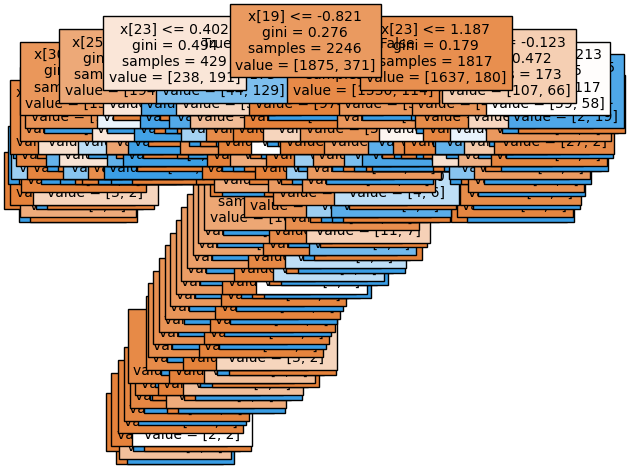

In [32]:
from sklearn.tree import plot_tree

for idx, feature in enumerate(X.columns):
    print(f"{idx}: {feature}")

#plt.figure(figsize=(20, 10))
plot_tree(grids["Tree"].best_estimator_, filled=True, fontsize=10)
plt.savefig("tree.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()